In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

#plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly import tools
import plotly.offline  as py
py.init_notebook_mode(connected=True)

# matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import statsmodels.api as sm

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

# Task description

The key aspect of ride-hailing is upfront pricing, which works the following way. First, it predicts the price for a ride based on predicted distance and time. This price is what you see on the screen of the phone before ordering a ride. Second, if the metered price based on actual distance and time differs a lot from the predicted one, the upfront price switches to the metered price. 'A lot' means by more than 20%. For example, suppose you want to make a ride that upfront price predicts to cost 5 euros. If the metered price is between 4 and 6 euros - the rider pays 5 euros, otherwise the metered price.
We would like to improve the upfront pricing precision. Kindly analyze the data and identify top opportunities for that. Could you name the top one opportunity?

order_id_new, order_try_id_new - id of an order
calc_created- time when the order was created
metered_price, distance, duration - actual price, distance and duration of a ride
upfront_price- promised to the rider price, based on predicted duration (predicted_duration) and distance (predicted_distance)
distance - ride distance
duration - ride duration
gps_confidence- indicator for good GPS connection (1 - good one, 0 - bad one)
entered_by- who entered the address
b_state- state of a ride (finished implies that the ride was actually done)
dest_change_number- number of destination changes by a rider and a driver. It includes the original input of the destination by a rider. That is why the minimum value of it is 1
predicted distance - predicted duration of a ride based on the pickup and dropoff points entered by the rider requesting a car
predicted duration - predicted duration of a ride based on the pickup and dropoff points entered by the rider requesting a car
prediction_price_type- internal variable for the type of prediction:
upfront, prediction - prediction happened before the ride
upfront_destination_changed - prediction happened after rider changed destination during the ride
change_reason_pricing - indicates whose action triggered a change in the price prediction. If it is empty, it means that either nobody changed the destination or that the change has not affected the predicted price
ticket_id_new - id for customer support ticket
device_token, device_token_new - id for a device_token (empty for all the fields)
rider_app_version - app version of rider phone
driver_app_version- app version of driver phone
driver_device_uid_new - id for UID of a phone device
device_name- the name of the phone
eu_indicator- whether a ride happens in EU
overpaid_ride_ticket- indicator for a rider complaining about the overpaid ride
fraud_score- fraud score of a rider. The higher it is the more likely the rider will cheat.


Part II: Business Research
Please create an assessment for food delivery (courier delivery of food from restaurants) launch in a city of your choice. The output should be a spreadsheet including the following:
A top-down estimation of market size
Unit economics with profitability per order

# Functions

In [3]:
def build_conf_int(metrics_df_cl, group_col, calc_col, bins=20):
    
    metrics_df_cl = metrics_df_cl[[calc_col, group_col]]
    print('Corr:', metrics_df_cl.corr().iloc[0,1])
    metrics_df_cl[group_col] = pd.cut(metrics_df_cl[group_col], bins=bins)
    
    metrics_df_ci = metrics_df_cl.groupby(group_col)[calc_col].apply(lambda x:\
                            [float(i) for i in str(bs.bootstrap(np.array(x), stat_func=bs_stats.mean))\
                            .replace('(','').replace(')','').replace(',','').split()])

    metrics_df_ci = pd.DataFrame(list(metrics_df_ci), columns=('mean','left','right'), 
                                 index=list(metrics_df_ci.index)).dropna()
    metrics_df_ci = metrics_df_ci[~(metrics_df_ci['mean'].isin([0]))]
    metrics_df_ci.index = metrics_df_ci.index.astype('str')
    x = list(metrics_df_ci.index)
    y = list(metrics_df_ci['mean'])
    y_upper = list(metrics_df_ci['left'])
    y_lower = list(metrics_df_ci['right'])
    
    fig = go.Figure([
        go.Scatter(
            x=x,
            y=y,
            line=dict(color='#2241D1'),
            mode='lines',
            name=calc_col
        ),
        go.Scatter(
            x=x+x[::-1], # x, then x reversed
            y=y_upper+y_lower[::-1], # upper, then lower reversed
            fill='toself',
            fillcolor='#2241D1',
            opacity=0.2,
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=False
        )
    ])


    xaxis_params = dict(title=group_col,
                           showgrid=True)

    fig.update_layout(title='Conf int of the relation between {} and {}'.format(group_col,calc_col), 
                           xaxis=go.layout.XAxis(**xaxis_params), 
                           yaxis=dict(title=calc_col,
                                     showgrid=True)
                           , width=700
                           , height=450)
    fig.show()

def print_mse_rmse(y_true,y_pred):
    print('mse: {:.4f}, rmse: {:.4f}'.format(mse(y_true,y_pred),np.sqrt(mse(y_true,y_pred))))
    
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Data overview

In [4]:
df = pd.read_csv('data/test.csv')

## Transform data

After manual check of the data I found out that:
- it is possible to use any of ids, they doesn't relate to each other. Also in column order_try_id_new the earlier orders are related to earlier ids, so I'll take this column as id
- there are dublicates of ids with difference in number of tickets to support and overpaid ride

In [5]:
# delete duplicates: ticket_id_new and overpaid_ride_ticket
final_df = df.drop(['ticket_id_new'], axis=1).drop_duplicates().sort_values('overpaid_ride_ticket')\
            .groupby('order_try_id_new').last().reset_index()\
            .merge(df.groupby('order_try_id_new').ticket_id_new.nunique()\
                   .reset_index().rename({'ticket_id_new':'tickets_cnt'}, axis=1), on='order_try_id_new')

# drop unnecessary cols
final_df = final_df.drop(['order_id_new','b_state','device_token','order_state','order_try_state'], axis=1)\
       .rename({'order_try_id_new':'order_id', 'driver_device_uid_new':'driver_id'}, axis=1)

bin_feature_lst = ['gps_confidence', 'eu_indicator', 'overpaid_ride_ticket']
cat_feature_lst = ['entered_by','dest_change_number','prediction_price_type', 'change_reason_pricing',
                  'rider_app_version', 'driver_app_version','device_name']
cont_feature_lst = ['fraud_score', 'metered_price', 'distance', 'duration', 
                    'upfront_price', 'predicted_duration', 'predicted_distance']

y = final_df['metered_price']
col_dis = ['distance']
col_dur = ['duration']
y_pred = final_df['upfront_price']
col_dis_pred = ['predicted_distance']
col_dur_pred = ['predicted_duration']

In [6]:
final_df.columns

Index(['order_id', 'calc_created', 'metered_price', 'upfront_price',
       'distance', 'duration', 'gps_confidence', 'entered_by',
       'dest_change_number', 'prediction_price_type', 'predicted_distance',
       'predicted_duration', 'change_reason_pricing', 'rider_app_version',
       'driver_app_version', 'driver_id', 'device_name', 'eu_indicator',
       'overpaid_ride_ticket', 'fraud_score', 'tickets_cnt'],
      dtype='object')

## Statistics

In [7]:
final_df[bin_feature_lst+cont_feature_lst].describe().T

,count,mean,std,min,25%,50%,75%,max
gps_confidence,4166.0,0.817091,0.386639,0.0,1.00,1.00,1.00,1.00
eu_indicator,4166.0,0.596255,0.490706,0.0,0.00,1.00,1.00,1.00
overpaid_ride_ticket,4166.0,0.074172,0.262082,0.0,0.00,0.00,0.00,1.00
fraud_score,1928.0,-679.027490,1117.399370,-14225.0,-836.50,-280.00,-63.75,49.00
metered_price,4147.0,7019.152703,14501.768893,2.0,5.18,10.78,9000.00,194483.52
distance,4166.0,9482.638502,10763.054556,0.0,3745.00,6918.50,11637.75,233190.00
duration,4166.0,1488.743879,1586.835074,0.0,595.25,1019.50,1811.75,22402.00
upfront_price,2946.0,3730.913951,17689.957766,2.0,4.10,6.40,17.10,595000.00
predicted_duration,4147.0,1082.257053,816.149391,0.0,590.50,916.00,1371.50,20992.00
predicted_distance,4147.0,8758.412587,11101.856197,0.0,4086.50,6777.00,10569.50,353538.00


In [8]:
final_df.groupby('eu_indicator')[['distance', 'predicted_distance',
                                  'duration', 'predicted_duration']].agg(['mean'])

,distance,predicted_distance,duration,predicted_duration
,mean,mean,mean,mean
eu_indicator,,,,
0,10410.241379,9833.901308,2148.800238,1401.732461
1,8854.527375,8024.549696,1041.797504,864.262069


### Distribution and mean

In [9]:
for co in cont_feature_lst:
    fig = px.histogram(final_df[(final_df[co]<=final_df[co].quantile(.99))&
                                (final_df[co]>=final_df[co].quantile(.01))][co], height=400, width=600,
                      title='Distribution: {}'.format(co), marginal='box')
    fig.show()

In [10]:
for eu in [0,1]:
    for co in ['metered_price', 'upfront_price']:
        print('EU:',eu)
        fig = px.histogram(final_df[(final_df[co]<=final_df[co].quantile(.99))&
                                    (final_df[co]>=final_df[co].quantile(.01))&
                                    (final_df['eu_indicator']==eu)][co], height=400, width=600,
                          title='Distribution: {}'.format(co), marginal='box')
        fig.show()

EU: 0


EU: 0


EU: 1


EU: 1


In [11]:
for cat in cat_feature_lst:
    print('---',cat.upper(),final_df[cat].count(), 'total:', final_df['eu_indicator'].count())
    print(100*final_df[cat].value_counts(normalize=True).iloc[:20])

--- ENTERED_BY 4166 total: 4166
client      95.343255
driver       4.536726
reseller     0.120019
Name: entered_by, dtype: float64
--- DEST_CHANGE_NUMBER 4166 total: 4166
1     91.862698
2      5.424868
3      1.848296
4      0.504081
5      0.216035
7      0.048008
6      0.048008
9      0.024004
12     0.024004
Name: dest_change_number, dtype: float64
--- PREDICTION_PRICE_TYPE 4147 total: 4166
upfront                        71.545696
prediction                     24.065590
upfront_destination_changed     4.316373
upfront_waypoint_changed        0.072341
Name: prediction_price_type, dtype: float64
--- CHANGE_REASON_PRICING 255 total: 4166
driver_destination_changed    49.803922
client_destination_changed    48.235294
driver_waypoint_changed        1.960784
Name: change_reason_pricing, dtype: float64
--- RIDER_APP_VERSION 4151 total: 4166
CI.4.17    14.526620
CI.4.19    13.153457
CA.5.44    11.153939
CA.5.43     8.335341
CA.5.42     7.082631
CI.4.18     5.613105
CA.5.46     4.962660
C

### Mofify features

In [12]:
# add and modify features
final_df['is_entered_by_driver'] = np.where(final_df.entered_by=='driver', 1, 0)
final_df['is_dest_changed'] = np.where(final_df.dest_change_number>1, 1, 0)
final_df['is_big_price_difference'] = np.where(np.abs((final_df.metered_price-final_df.upfront_price)/\
                                                final_df.upfront_price)>=0.2, 1, 0)
final_df['is_big_pos_price_difference'] = np.where((final_df.metered_price-final_df.upfront_price)/\
                                                final_df.upfront_price>=0.2, 1, 0)
final_df['price_diff_share'] = (final_df.metered_price-final_df.upfront_price)/\
                                                final_df.upfront_price
final_df['price_diff_share_abs'] = final_df['price_diff_share'].apply(lambda x:np.abs(x))

norm_coef = final_df[final_df.eu_indicator==0].upfront_price.median()/\
                    final_df[final_df.eu_indicator==1].upfront_price.median()

final_df['upfront_price_norm'] = np.where(final_df.eu_indicator==0, final_df.upfront_price/norm_coef,
                                          final_df.upfront_price)
final_df['metered_price_norm'] = np.where(final_df.eu_indicator==0, final_df.metered_price/norm_coef,
                                          final_df.metered_price)

# df with predicted dist and time but with n/a in upfront price
final_dist_df = final_df[~final_df.metered_price.isnull()]
# delete n/a 
final_df = final_df[~final_df.upfront_price.isnull()]
final_df['fraud_score'] = final_df.fraud_score.fillna(final_df.fraud_score.mean())

In [13]:
final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_id,2946.0,1822.158181,1217.942250,0.000000,781.250000,1562.500000,2867.500000,4165.000000
metered_price,2946.0,4223.478184,12787.380928,2.000000,4.400000,7.080000,19.277500,194483.520000
upfront_price,2946.0,3730.913951,17689.957766,2.000000,4.100000,6.400000,17.100000,595000.000000
distance,2946.0,8891.459606,9925.498572,0.000000,3698.250000,6499.000000,10930.500000,171119.000000
duration,2946.0,1204.523761,1238.036198,0.000000,538.500000,887.000000,1406.500000,18734.000000
gps_confidence,2946.0,0.901561,0.297957,0.000000,1.000000,1.000000,1.000000,1.000000
dest_change_number,2946.0,1.064834,0.369746,1.000000,1.000000,1.000000,1.000000,7.000000
predicted_distance,2946.0,8465.264087,11524.806484,21.000000,3876.250000,6335.000000,10159.750000,353538.000000
predicted_duration,2946.0,996.000000,816.706631,2.000000,551.250000,832.000000,1219.000000,20992.000000
driver_id,2946.0,1087.101494,632.226604,0.000000,541.500000,1099.500000,1642.500000,2158.000000


### Relation of features and prediction precision

In [49]:
# cat = 'eu_indicator'
# a = pd.concat([final_df.groupby(cat)[target_cols].mean(),
#                    final_df.groupby(cat)[target_cols].count()/\
#                    final_df[target_cols].count()],axis=1, keys=('share_metric','share_orders'))
# a = a.unstack().reset_index().rename({'level_0':'metric_type','level_1':'metric_name', 0:'value'}, axis=1)
# a[cat] = a[cat].astype('str')
# a = a[a[cat].isin(list(a[(a.metric_type=='share_orders')&(a['value']>=0.01)][cat]))&
#         (a.metric_type!='share_orders')].drop(['metric_type'], axis=1)
# fig = px.bar(a.set_index('metric_name'),color=cat, barmode='group',width=600, height=450,
#                       title='Share of over/underpaid orders by {}'.format(cat))
# fig.show()

In [14]:
target_cols = ['is_big_price_difference', 'is_big_pos_price_difference', 
               'overpaid_ride_ticket', 'price_diff_share_abs']
for cat in cat_feature_lst[:2]+cat_feature_lst[4:]+['tickets_cnt', 'is_dest_changed']+bin_feature_lst[:-1]:

    print('-------------------', cat.upper())
    a = pd.concat([final_df.groupby(cat)[target_cols].mean(),
                   final_df.groupby(cat)[target_cols].count()/\
                   final_df[target_cols].count()],axis=1, keys=('share_metric','share_orders'))
    a = a.unstack().reset_index().rename({'level_0':'metric_type','level_1':'metric_name', 0:'value'}, axis=1)
    a[cat] = a[cat].astype('str')
    a = a[a[cat].isin(list(a[(a.metric_type=='share_orders')&(a['value']>=0.01)][cat]))]
    
    fig = px.bar(a.set_index('metric_name'),color=cat, facet_col='metric_type', barmode='group',
                      title='Share of orders and target metric: {}'.format(cat))
    fig.show()

------------------- ENTERED_BY


------------------- DEST_CHANGE_NUMBER


------------------- RIDER_APP_VERSION


------------------- DRIVER_APP_VERSION


------------------- DEVICE_NAME


------------------- TICKETS_CNT


------------------- IS_DEST_CHANGED


------------------- GPS_CONFIDENCE


------------------- EU_INDICATOR


In [18]:
col = 'fraud_score'
for i in target_cols:
    build_conf_int(final_dist_df[(final_dist_df[col]>=final_dist_df[col].quantile(0.01))&
                                (final_dist_df[col]<=final_dist_df[col].quantile(0.99))], col, i, 20)

Corr: -0.014854791130964284


Corr: -0.007683056599683943


Corr: -0.022059815774556832


Corr: 0.004386037719481914


In [19]:
col = 'distance'
for eu in [0,1]:
    for i in target_cols:
        print('EU:',eu)
        build_conf_int(final_df[(final_df[col]>=final_df[col].quantile(0.01))&
                                    (final_df[col]<=final_df[col].quantile(0.95))&
                               (final_df.eu_indicator==eu)], col, i, 10)

EU: 0
Corr: 0.09210113373372948


EU: 0
Corr: 0.5269074141761987


EU: 0
Corr: 0.04522552362230547


EU: 0
Corr: 0.3880879598588232


EU: 1
Corr: -0.0021616908051569554


EU: 1
Corr: 0.13308845213453874


EU: 1
Corr: -0.012158321042121802


EU: 1
Corr: 0.01609986612724495


In [20]:
col = 'duration'
for eu in [0,1]:
    for i in target_cols:
        print('EU:',eu)
        build_conf_int(final_df[(final_df[col]>=final_df[col].quantile(0.01))&
                                    (final_df[col]<=final_df[col].quantile(0.95))&
                               (final_df.eu_indicator==eu)], col, i, 10)

EU: 0
Corr: 0.07181015531994549


EU: 0
Corr: 0.45967104302764283


EU: 0
Corr: -0.0023324002270937835


EU: 0
Corr: 0.21402385536634802


EU: 1
Corr: 0.13850356297220284


EU: 1
Corr: 0.27330136533962934


EU: 1
Corr: 0.07765071342363845


EU: 1
Corr: 0.19737985492114066


In [21]:
final_df.groupby('eu_indicator').gps_confidence.mean()

eu_indicator
0    0.669643
1    0.970097
Name: gps_confidence, dtype: float64

**Intermediate conclusions**

The bigger price difference is related to this cases:
- destination entered by driver
- number of destinations was changed 3 times
- some older driver/rider app versions that are not popular
- destination was changed
- bad gps
- order outside eu

Continuous varibles:
- Fraud score doesn't correlate with bad precision of prediction.
- Both distance and duration are related to big price difference in nonEU area - on long distance/duration differencce is bigger and more ovepays. That means that there are some problems with predictions on long rides outside EU. Also in nonEU countries GPS connection is bad much more often, so it may be the reason

# Quality of distance/duration/price model

In [22]:
scaler = StandardScaler()
final_sc_df = final_df.copy()

In [23]:
# Price
# r2
scaler.fit(final_sc_df[['upfront_price_norm']])
final_sc_df['scaled_upfront_price'] = scaler.transform(final_sc_df[['upfront_price_norm']])
final_sc_df['scaled_metered_price'] = scaler.transform(final_sc_df[['metered_price_norm']])

print_mse_rmse(final_sc_df['scaled_upfront_price'], final_sc_df['scaled_metered_price'])
# r2
print('r2:',r2_score(final_df['upfront_price'],final_df['metered_price']))
# mape
print('MAPE:',final_df['price_diff_share_abs'].sum()/final_df['price_diff_share_abs'].count())

mse: 0.8970, rmse: 0.9471
r2: 0.05699933239453836
MAPE: 0.29879956393702806


In [24]:
# Distance
scaler.fit(final_sc_df[['distance']])
final_sc_df['scaled_distance'] = scaler.transform(final_sc_df[['distance']])
final_sc_df['scaled_predicted_distance'] = scaler.transform(final_sc_df[['predicted_distance']])
print_mse_rmse(final_sc_df['scaled_distance'], final_sc_df['scaled_predicted_distance'])

# r2
print(r2_score(final_sc_df['scaled_distance'],final_sc_df['scaled_predicted_distance']))

# mape
final_df['distance_diff_share_abs'] = ((final_df.predicted_distance-final_df['distance'])/\
                                            final_df.predicted_distance).apply(lambda x:np.abs(x))
print(final_df['distance_diff_share_abs'].sum()/final_df['distance_diff_share_abs'].count())

mse: 1.0051, rmse: 1.0026
-0.0051381641383836385
0.3779490953259177


In [25]:
# Duration
scaler.fit(final_sc_df[['duration']])
final_sc_df['scaled_duration'] = scaler.transform(final_sc_df[['duration']])
final_sc_df['scaled_predicted_duration'] = scaler.transform(final_sc_df[['predicted_duration']])

print_mse_rmse(final_sc_df['scaled_duration'], final_sc_df['scaled_predicted_duration'])

# r2
print(r2_score(final_df['duration'],final_df['predicted_duration']))
# mape
final_df['duration_diff_share_abs'] = ((final_df.predicted_duration-final_df['duration'])/\
                                            final_df.predicted_duration).apply(lambda x:np.abs(x))
print(final_df['duration_diff_share_abs'].sum()/final_df['duration_diff_share_abs'].count())

mse: 0.8068, rmse: 0.8982
0.1932433271634505
0.49291206471121835


In [26]:
# distibution of errors
final_df['distance_diff_share'] = ((final_df.predicted_distance-final_df['distance'])/\
                                            final_df.predicted_distance)
final_df['duration_diff_share'] = ((final_df.predicted_duration-final_df['duration'])/\
                                            final_df.predicted_duration)

for c in ['price_diff_share', 'distance_diff_share', 'duration_diff_share']:
    fig = px.histogram(final_df[(final_df[c]<=final_df[c].quantile(.99))&
                                    (final_df[c]>=final_df[c].quantile(.01))][c], height=400, width=600,
                          title='Distribution: {}'.format(c), marginal='box')
    fig.show()

- Distance has worse R2 metric, but better mean abs percentage error than duration. 
- Duration vary on average by 49% (about half), distance - 37%, price - 29%

Now let's build regression models that will help to find the most important variables

# Regression model

We don't have variables to predict duration or distance but can use them and other variables to predict upfront price

In [27]:
model_data = final_df.set_index('order_id')[['distance', 'duration', 'gps_confidence','is_dest_changed',
          'is_entered_by_driver','eu_indicator','fraud_score', 'upfront_price', 'metered_price',
                                             'upfront_price_norm', 'metered_price_norm',
                                            'predicted_distance','predicted_duration']]

In [28]:
model_data.describe().T

,count,mean,std,min,25%,50%,75%,max
distance,2946.0,8891.459606,9925.498572,0.000000,3698.250000,6499.000000,10930.5000,171119.000000
duration,2946.0,1204.523761,1238.036198,0.000000,538.500000,887.000000,1406.5000,18734.000000
gps_confidence,2946.0,0.901561,0.297957,0.000000,1.000000,1.000000,1.0000,1.000000
is_dest_changed,2946.0,0.037678,0.190449,0.000000,0.000000,0.000000,0.0000,1.000000
is_entered_by_driver,2946.0,0.016633,0.127913,0.000000,0.000000,0.000000,0.0000,1.000000
eu_indicator,2946.0,0.771894,0.419682,0.000000,1.000000,1.000000,1.0000,1.000000
fraud_score,2946.0,-693.073799,882.864600,-14225.000000,-693.073799,-693.073799,-208.0000,49.000000
upfront_price,2946.0,3730.913951,17689.957766,2.000000,4.100000,6.400000,17.1000,595000.000000
metered_price,2946.0,4223.478184,12787.380928,2.000000,4.400000,7.080000,19.2775,194483.520000
upfront_price_norm,2946.0,6.775761,8.947666,0.945455,3.700000,5.200000,7.7000,281.272727


In [29]:
final_df.groupby('is_dest_changed').is_entered_by_driver.mean(),\
final_df.groupby('eu_indicator').is_entered_by_driver.mean(),\
final_df.groupby('eu_indicator').is_dest_changed.mean()

(is_dest_changed
 0    0.000000
 1    0.441441
 Name: is_entered_by_driver, dtype: float64,
 eu_indicator
 0    0.000000
 1    0.021548
 Name: is_entered_by_driver, dtype: float64,
 eu_indicator
 0    0.052083
 1    0.033421
 Name: is_dest_changed, dtype: float64)

## Corr matrix

<AxesSubplot:title={'center':'Correlation matrix'}>

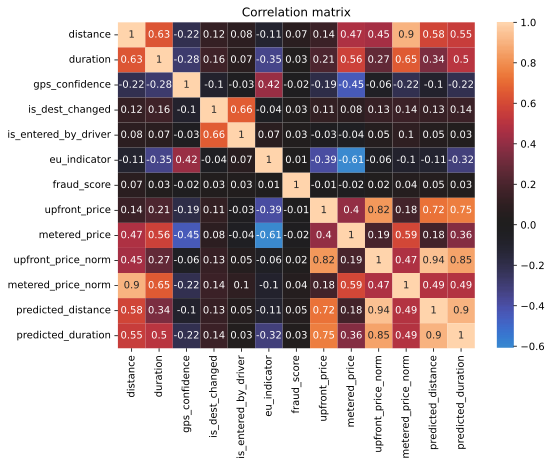

In [30]:
plt.figure(figsize=(8,6))
plt.title('Correlation matrix')
sns.heatmap(round(model_data.corr(),2), annot=True, center=0)

Correlation between features is less than 0.7 so we can take all of them (maybe except is_entered_by_driver)

## Simple linreg

In [31]:
# upfront price prediction normalized
X = model_data[['predicted_distance', 'predicted_duration']]
y = model_data['upfront_price_norm']
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
ypred = results.predict(X)
print('mape:',mape(y,ypred), 'r2:',r2_score(y,ypred))
print('all errors share:',np.where(np.abs((y-ypred)/ypred)>=0.2,1,0).mean(), 
          'overpays share:', np.where((y-ypred)/y>=0.2,1,0).mean())
# print(results.params)
results.summary()

mape: 0.24067296426150084 r2: 0.8855878016544205
all errors share: 0.41683638832315 overpays share: 0.2318397827562797


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     upfront_price_norm   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                 1.139e+04
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:00:03   Log-Likelihood:                -7442.1
No. Observations:                2946   AIC:                         1.489e+04
Df Residuals:                    2943   BIC:                         1.491e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3872      0.100      3.891      0.000       0.192       0.582
predicted_distance     0.0007   1.11e-05     63.182      0.000       0.001       0.001
predicted_duration     0.0004      0.000      2.864      0.004       0.000       0.001
==============================================================================
Omnibus:                     4239.643   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6857207.326
Skew:                           7.775   Prob(JB):                         0.00
Kurtosis:                     238.842   Cond. No.                     2.56e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
# metered price prediction
X = model_data[['predicted_distance', 'predicted_duration']]
y = model_data['metered_price_norm']
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
ypred = results.predict(X)
print('mape:',mape(y,ypred), 'r2:',r2_score(y,ypred))
print_mse_rmse(y,ypred)
print('all errors share:',np.where(np.abs((y-ypred)/ypred)>=0.2,1,0).mean(), 
          'overpays share:', np.where((y-ypred)/y>=0.2,1,0).mean())
# print(results.params)
results.summary()

mape: 0.574200983044962 r2: 0.2568189128187994
mse: 38.2912, rmse: 6.1880
all errors share: 0.6524100475220638 overpays share: 0.17515274949083504


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     metered_price_norm   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     508.5
Date:                Sun, 24 Apr 2022   Prob (F-statistic):          2.07e-190
Time:                        14:00:04   Log-Likelihood:                -9549.6
No. Observations:                2946   AIC:                         1.911e+04
Df Residuals:                    2943   BIC:                         1.912e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.8642      0.203     18.990      0.000       3.465       4.263
predicted_distance     0.0002   2.27e-05      7.343      0.000       0.000       0.000
predicted_duration     0.0022      0.000      6.914      0.000       0.002       0.003
==============================================================================
Omnibus:                     1965.596   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           665201.902
Skew:                           1.980   Prob(JB):                         0.00
Kurtosis:                      76.508   Cond. No.                     2.56e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
# metered price prediction
# change dest is unncessary (by p-value with 5% confidence)
X = model_data.drop(['upfront_price', 'metered_price','upfront_price_norm', 'metered_price_norm',
                    'is_dest_changed','distance', 'duration', 'fraud_score'], axis=1)
y = model_data['metered_price_norm']
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
ypred = results.predict(X)
print('mape:',mape(y,ypred), 'r2:',r2_score(y,ypred))
print_mse_rmse(y,ypred)
print('all errors share:',np.where(np.abs((y-ypred)/ypred)>=0.2,1,0).mean(), 
          'overpays share:', np.where((y-ypred)/y>=0.2,1,0).mean())
# print(results.params)
results.summary()

mape: 0.5423120569730325 r2: 0.2885724816483952
mse: 36.6551, rmse: 6.0543
all errors share: 0.6255940257976917 overpays share: 0.17175831636116767


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     metered_price_norm   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     238.5
Date:                Sun, 24 Apr 2022   Prob (F-statistic):          2.83e-214
Time:                        14:00:05   Log-Likelihood:                -9485.3
No. Observations:                2946   AIC:                         1.898e+04
Df Residuals:                    2940   BIC:                         1.902e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.8402      0.507     13.481      0.000       5.845       7.835
gps_confidence          -4.2905      0.418    -10.261      0.000      -5.110      -3.471
is_entered_by_driver     3.8146      0.879      4.342      0.000       2.092       5.537
eu_indicator             1.3109      0.331      3.963      0.000       0.662       1.960
predicted_distance       0.0002   2.49e-05      7.057      0.000       0.000       0.000
predicted_duration       0.0020      0.000      5.303      0.000       0.001       0.003
==============================================================================
Omnibus:                     1945.298   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           669055.800
Skew:                           1.938   Prob(JB):                         0.00
Kurtosis:                      76.726   Cond. No.                     1.13e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

New model only with distance and duration shows much better results than old model. Maybe problem is in price normalizing, can't say exactly because don't know how previous model was built

## Importance of features

In [34]:
X_scaled = scaler.fit_transform(model_data.drop(['upfront_price', 'metered_price',
                                                 'upfront_price_norm', 'metered_price_norm',
                    'is_dest_changed','distance', 'duration', 'fraud_score'], axis=1))
y = model_data['metered_price_norm']
X_scaled = sm.add_constant(X_scaled)
model2 = sm.OLS(y,X_scaled)
results2 = model2.fit()

In [35]:
cols = list(X.columns)
vals = list(dict(results2.params).values())
np.abs(pd.Series(dict(zip(cols, vals)))).sort_values(ascending=False)

const                   7.483843
predicted_distance      2.022172
predicted_duration      1.599370
gps_confidence          1.278172
eu_indicator            0.550089
is_entered_by_driver    0.487854
dtype: float64

In [36]:
pd.Series(dict(zip(cols, vals))).sort_values(ascending=False)

const                   7.483843
predicted_distance      2.022172
predicted_duration      1.599370
eu_indicator            0.550089
is_entered_by_driver    0.487854
gps_confidence         -1.278172
dtype: float64

The most important feature is distance, the second - duration. After that goes gps_confidence, then eu_indicator and entered by driver dest

In [37]:
# metrics in old model
print('mape:',mape(final_df['metered_price_norm'],final_df['upfront_price_norm']), 
      'r2:',r2_score(final_df['metered_price_norm'],final_df['upfront_price_norm']))
print_mse_rmse(final_df['metered_price_norm'],final_df['upfront_price_norm'])
print('all errors share:',final_df.is_big_price_difference.mean(), 
          'overpays share:', final_df.is_big_pos_price_difference.mean())

mape: 0.30587100586500654 r2: -0.3933962728007898
mse: 71.7924, rmse: 8.4730
all errors share: 0.45824847250509165 overpays share: 0.35234215885947046


In [38]:
X = model_data[['predicted_distance', 'predicted_duration']]
y = model_data['metered_price_norm']
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
ypred = results.predict(X)
print('mape:',mape(y,ypred), 'r2:',r2_score(y,ypred))
print_mse_rmse(y,ypred)
print('all errors share:',np.where(np.abs((y-ypred)/ypred)>=0.2,1,0).mean(), 
          'overpays share:', np.where((y-ypred)/y>=0.2,1,0).mean())
# print(results.params)

mape: 0.574200983044962 r2: 0.2568189128187994
mse: 38.2912, rmse: 6.1880
all errors share: 0.6524100475220638 overpays share: 0.17515274949083504


## Trying more models

In [39]:
X = model_data.drop(['upfront_price', 'metered_price',
                                                 'upfront_price_norm', 'metered_price_norm',
                    'is_dest_changed','distance', 'duration', 'fraud_score'], axis=1)
y = model_data['metered_price_norm']


for model, name in zip([LinearRegression, Ridge, Lasso, ElasticNet],
                ['lr', 'ridge', 'lasso', 'eln']):
    print('----', name)
    model = model()
    model.fit(X, y)
    ypred = model.predict(X)
    print('mape:',mape(y,ypred), 'r2:',r2_score(y,ypred))
    print_mse_rmse(y,ypred)
    print('all errors share:',np.where(np.abs((y-ypred)/ypred)>=0.2,1,0).mean(), 
          'overpays share:', np.where((y-ypred)/y>=0.2,1,0).mean())

---- lr
mape: 0.542312056973374 r2: 0.2885724816483952
mse: 36.6551, rmse: 6.0543
all errors share: 0.6255940257976917 overpays share: 0.17175831636116767
---- ridge
mape: 0.5424749352597233 r2: 0.2885700230952175
mse: 36.6552, rmse: 6.0544
all errors share: 0.6262729124236253 overpays share: 0.1710794297352342
---- lasso
mape: 0.5742337112757441 r2: 0.25681874317449804
mse: 38.2912, rmse: 6.1880
all errors share: 0.6524100475220638 overpays share: 0.17515274949083504
---- eln
mape: 0.5742172707292634 r2: 0.2568188696137891
mse: 38.2912, rmse: 6.1880
all errors share: 0.6524100475220638 overpays share: 0.17515274949083504


Linear regression seems to show the best metrics

# Conclusions

**Insights about features**

The big price difference is more often in cases when:
- Destination was changed and the driver entered the destination. It is related because in all cases when driver entered the destination it was changed. Share of orders with big price difference (>20%) is 60% vs 45% on average
- GPS connection was bad - share of cases with big diff is 71% vs 45% on average. Bad connection is more frequent in nonEU contries (3% bad conn in EU and 33% in nonEU)
- Country is outside EU - share of cases with big diff is 57% vs 45% on average
- Distance and duration is long in nonEU countries. For distance higher than 15000 share of big price diff grows to ~80-90% and for duration bigger than 2000 it grows to ~66%. This may be the cause of bad gps connection

Fraud score doesn't correlate with prediction errors. 

**Model**

We don't know how the previous model was built but can compare the new model based on only destination and duration and model that includes other features.

The model without new features has R2=0.2568, model with features has R2=0.2886. MSE, RMSE, MAPE and share of big errors (>20%) also got better:
- MSE: 38.2912->36.6551
- RMSE: 6.1880->6.0543
- MAPE: 0.5742->0.5423
- Share all errors: 0.6524->0.6255
- Share overpays: 0.1752->0.1717

This is not a huge increase but it means that we can use features from model for prediction.

**The significance of features:**

Absolute scaled model coefficients:
- predicted_distance      2.022
- predicted_duration      1.599
- gps_confidence          1.278
- eu_indicator            0.550
- is_entered_by_driver    0.487

Model: 6.8402 + 3.8146*is_entered_by_driver + 1.3109*eu_indicator + 0.001959*predicted_duration + 0.000175*predicted_distance - 4.2905*gps_confidence

All those features are significant (by p-value) and coefficients describe the importance of features. So **the top one feature after distance and duration is quality of GPS connection**. It has negative sign so if connection is bad the price gets higher. Other variables has positive signes.

**Recommendations:**
- The top one opportunity to improve precision is considering GPS confidence in model. If it is bad - the price should be higher. 
- The second option may be in using indicator of EU/nonEU countries in model. In this case it would be nice to have an additional research about causes of the forecasting errors outside EU. It could be not only GPS connection but also problems with some kind of maps in country or wrong calculation of traffic jams
- The last significant feature is entering destination by driver. In all cases destination changes after it. There also may be pitfalls that require deeper analysis